# Variational AutoEncoders: Compact Compressions are Even Better Friends!

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from celluloid import Camera
from IPython.display import HTML
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST

In [2]:
### Prep Dataset ###
tensor_transforms = transforms.Compose(
    [
        transforms.ToTensor()
    ]
)
train_set = MNIST("../../../data/mnist/", train=True, transform=tensor_transforms)
test_set = MNIST("../../../data/mnist/", train=False, transform=tensor_transforms)

In [3]:
class LinearVariationalAutoEncoder(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256), 
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
        )

        self.fn_mu =  nn.Linear(64, latent_dim)
        self.fn_logvar = nn.Linear(64, latent_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.Sigmoid()
        )

    def forward_enc(self, x):

        x = self.encoder(x)
        
        mu = self.fn_mu(x)
        logvar = self.fn_logvar(x)

        ### Sample with Reparamaterization Trick ###
        sigma = torch.exp(0.5*logvar)
        noise = torch.rand_like(sigma, device=sigma.device)

        z = mu + sigma*noise

        return z, mu, logvar

    def forward_dec(self, x):
        return self.decoder(x)        
        
    def forward(self, x):

        batch, channels, height, width = x.shape
        
        ### Flatten Image to Vector ###
        x = x.flatten(1)

        ### Pass Through Encoder ###
        z, mu, logvar = self.forward_enc(x)

        ### Pass Sampled Data Through Decoder ###
        dec = self.decoder(z)

        ### Put Decoded Image Back to Original Shape ###
        dec = dec.reshape(batch, channels, height, width)

        return z, dec, mu, logvar

rand = torch.randn(4,1,28,28)
model = LinearVariationalAutoEncoder()
encoded, decoded, mu, logvar = model(rand)

In [4]:
def loss_fn(x, x_hat, mean, log_var):
    reproduction_loss = torch.nn.functional.mse_loss(x_hat, x)
    KLD = torch.mean(- 0.5 * torch.sum(1+ log_var - mean**2 - torch.exp(log_var), dim=-1))

    # print(reproduction_loss, KLD)
    return reproduction_loss + KLD * 0


In [5]:
def train(model,
          train_set,
          test_set,
          batch_size, 
          training_iterations, 
          evaluation_iterations):
    
    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = model.to(device)
    
    trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8)
    testloader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=8)

    optimizer = optim.Adam(model.parameters(), lr=0.0005)

    train_loss = []
    evaluation_loss = []
    
    encoded_data_per_eval = []
    train_losses = []
    evaluation_losses = []

    pbar = tqdm(range(training_iterations))
    
    train = True
    
    step_counter = 0
    while train:

        for images, labels in trainloader:
            
            images = images.to(device)

            encoded, decoded, mu, logvar = model(images)

            loss = loss_fn(images, decoded, mu, logvar)

            train_loss.append(loss.item())
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if step_counter % evaluation_iterations == 0:
                
                model.eval()
                
                encoded_evaluations = []

                for images, labels in testloader:

                    images = images.to(device)

                    encoded, decoded, mu, logvar = model(images)

                    loss = loss_fn(images, decoded, mu, logvar)

                    evaluation_loss.append(loss.item())

                    encoded, labels = encoded.cpu(), labels.reshape(-1,1)
                    
                    encoded_evaluations.append(torch.cat((encoded, labels), axis=-1))


                encoded_data_per_eval.append(torch.concatenate(encoded_evaluations).detach())

                train_loss = np.mean(train_loss)
                evaluation_loss = np.mean(evaluation_loss)

                train_losses.append(train_loss)
                evaluation_losses.append(evaluation_loss)
                
                train_loss = []
                evaluation_loss = []

                model.train()

            step_counter += 1
            pbar.update(1)
            
            if step_counter >= training_iterations:
                print("Completed Training!")
                train = False
                break

    encoded_data_per_eval = [np.array(i) for i in encoded_data_per_eval]

    print("Final Training Loss", train_losses[-1])
    print("Final Evaluation Loss", evaluation_losses[-1])
    
    return model, train_losses, evaluation_losses, encoded_data_per_eval

def plot_embedding_visual(encoded_data_per_eval, iterations_per_eval=250, path_to_save="encoding_vis"):
    
    fig, ax = plt.subplots()
    
    for idx, encoding in enumerate(encoded_data_per_eval):
        
        encoding = pd.DataFrame(encoding, columns=["x", "y", "class"])
        encoding = encoding.sort_values(by="class")
        encoding["class"] = encoding["class"].astype(int).astype(str)
    
        for grouper, group in encoding.groupby("class"):
            plt.scatter(x=group["x"], y=group["y"], label=grouper, alpha=0.8, s=5)
        
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        plt.axis('off')
        plt.title("Linear AutoEncoder Embeddings")
        plt.savefig(os.path.join(path_to_save, f"step_{idx*iterations_per_eval}.png"), dpi=300)

        plt.close()
        
def build_embedding_visual(encoded_data_per_eval, iterations_per_eval=100):

    fig, ax = plt.subplots()

    camera = Camera(fig)
    
    for idx, encoding in enumerate(encoded_data_per_eval):
        
        encoding = pd.DataFrame(encoding, columns=["x", "y", "class"])
        encoding = encoding.sort_values(by="class")
        encoding["class"] = encoding["class"].astype(int).astype(str)
    
        for grouper, group in encoding.groupby("class"):
            plt.scatter(x=group["x"], y=group["y"], label=grouper, alpha=0.8, s=5)
    
        ax.text(0.4, 1.01, f"Step {idx*iterations_per_eval}", transform=ax.transAxes, fontsize=12)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        
        camera.snap()
        
    plt.close()
    anim = camera.animate(blit=True)
    return anim


In [6]:
model = LinearVariationalAutoEncoder()
print(model)
model, train_losses, evaluation_losses, encoded_data_per_eval = train(model,
                                                                      train_set,
                                                                      test_set,
                                                                      batch_size=64,
                                                                      training_iterations=25000,
                                                                      evaluation_iterations=250)

LinearVariationalAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=64, bias=True)
    (5): ReLU()
  )
  (fn_mu): Linear(in_features=64, out_features=2, bias=True)
  (fn_logvar): Linear(in_features=64, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


  0%|          | 0/25000 [00:00<?, ?it/s]

Completed Training!
Final Training Loss 0.03391662334650755
Final Evaluation Loss 0.03464156098568895


In [7]:
anim = build_embedding_visual(encoded_data_per_eval)
HTML(anim.to_jshtml())


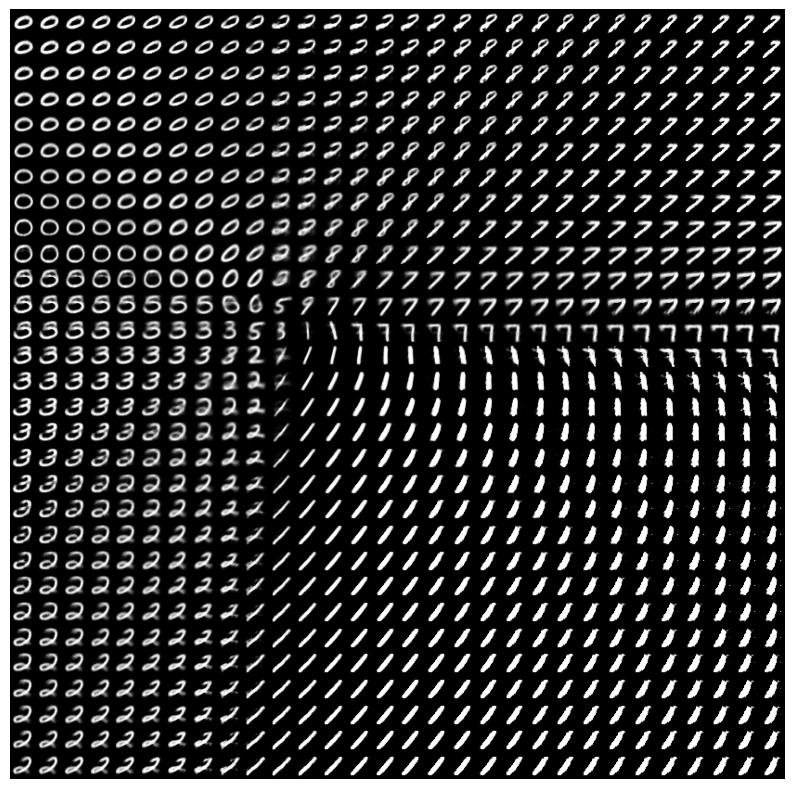

In [10]:
def interpolate_space(model, x_range=(-40,60), y_range=(-20,40), num_steps=30):

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    
    x_space = np.linspace(x_range[0], x_range[1], num_steps)
    y_space = np.linspace(y_range[0], y_range[1], num_steps)

    points = []
    for x in x_space:
        for y in y_space:
            points.append([x,y])

    points = torch.tensor(points, dtype=torch.float32).to(device)

    ### Pass Through Model Decoder and Reshape ###
    dec = model.forward_dec(points).detach().cpu()
    dec = dec.reshape(-1, 1, 28, 28)
    dec = dec.reshape((num_steps,num_steps, *dec.shape[1:]))

    fig, ax = plt.subplots(num_steps,num_steps, figsize=(10,10))

    for x in range(num_steps):
        for y in range(num_steps):
            
            img = np.array(dec[x,y].permute(1,2,0))
            ax[x,y].imshow(img, cmap="gray")
            ax[x,y].set_xticklabels([])
            ax[x,y].set_yticklabels([])
            ax[x,y].axis("off")

    fig.subplots_adjust(wspace=0, hspace=0)

interpolate_space(model)